In [1]:
import flopy
from pathlib import Path
import flopy.utils as fu
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import platform

### clean up from a previous run

In [2]:
cleanup = True
if cleanup is True:
    rundirs = Path('.')
    olddirs = [i for i in rundirs.glob('ps*') if os.path.isdir(i)]
    [shutil.rmtree(i) for i in olddirs];

# Look at the initial results from PS1

In [3]:
# first load in the initial model

In [4]:
if 'window' in platform.platform().lower():
    mfexe = os.path.abspath('../bin/mf6.exe')
else:
    mfexe = os.path.abspath('../bin/mf6')

In [5]:
# name the directories for the PS1a results and the PS2 initial directory
ps1_dir = Path('../PS1_flopy/PS1a/')
initial_dir = Path('./initial')
if not ps1_dir.exists():
    print('STOP HERE!\n\nYou need to run the PS1_flopy.ipynb notebook in PS1_flopy\n\n')
else:
    print('Just renamed PS1 to PS2 in the initial directory.')
    # Shenanigans to update the model naming from ps1 to ps2
    if initial_dir.exists():
        shutil.rmtree(initial_dir)
    shutil.copytree(ps1_dir, initial_dir)
    # rename all the files to "ps2"
    [shutil.move(i,str(i).replace('ps1','ps2')) for i in initial_dir.glob('ps1*')]
    for cf in initial_dir.glob('*.nam'):
        indat = [i.rstrip() for i in open(cf).readlines()]
        with open(cf, 'w') as ofp:
            [ofp.write(line.replace('ps1','ps2')+'\n') for line in indat]

Just renamed PS1 to PS2 in the initial directory.


In [6]:
sim = flopy.mf6.MFSimulation.load(sim_ws = './initial', exe_name=mfexe)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package chd...
    loading package chd...
    loading package oc...
  loading solution package ps2...


### reset the top to 400 feet

In [7]:
m = sim.get_model()
m.dis.top = 400

In [8]:
# run this as-is and look at the head file

In [9]:
sim.set_sim_path('./ps1')


In [10]:
sim.write_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ps2...
  writing model ps2...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package river...
    writing package canal...
    writing package oc...


In [11]:
sim.run_simulation()

FloPy is using the following executable to run the model: ../../bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.0 12/19/2024

        MODFLOW 6 compiled Dec 19 2024 21:26:44 with GCC version 13.3.0

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
functionality of the software and related material nor shall the 
fact of release constitute any such warranty. Furthermore, the 
software is released on condition that neither the USGS nor the U.S. 
Government shall be held liable for any damages resulting from its 
authorized or unauthorized use. Also refer to the USGS Water 
Resources Software User 

(True, [])

In [12]:
m1head = m.output.head().get_data()

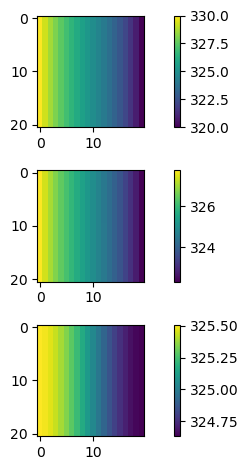

In [13]:
fig, ax = plt.subplots(3,1)
for i in range(m1head.shape[0]):
    d=ax[i].imshow(m1head[i])
    plt.colorbar(d)
    plt.tight_layout()

# Part A: The Recharge Package

### add rechage to the model and remove the canal (constant head on the left boundary)

In [14]:
sim.set_sim_path('ps2a') # redirect the directory for the model
m = sim.get_model()


In [15]:
r = flopy.mf6.ModflowGwfrcha(m,recharge=0.005)

In [16]:
chd_spd_canal = pd.DataFrame.from_records(m.chd[0].stress_period_data.array[0])
chd_spd_canal

,cellid,head
0,"(0, 0, 19)",320
1,"(0, 1, 19)",320
2,"(0, 2, 19)",320
3,"(0, 3, 19)",320
4,"(0, 4, 19)",320
5,"(0, 5, 19)",320
6,"(0, 6, 19)",320
7,"(0, 7, 19)",320
8,"(0, 8, 19)",320
9,"(0, 9, 19)",320


In [17]:
m.get_package_list()

['DIS', 'IC', 'NPF', 'RIVER', 'CANAL', 'OC', 'RCHA_0']

In [18]:
m.remove_package(m.CANAL)


In [19]:
m.get_package_list()

['DIS', 'IC', 'NPF', 'RIVER', 'OC', 'RCHA_0']

In [20]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ps2...
  writing model ps2...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package river...
    writing package oc...
    writing package rcha_0...
FloPy is using the following executable to run the model: ../../bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.0 12/19/2024

        MODFLOW 6 compiled Dec 19 2024 21:26:44 with GCC version 13.3.0

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
function

(True, [])

### exercise 1 and 2: look at the budgets

In [21]:
# recharge that should be applied
np.sum(m.dis.delr.array)*np.sum(m.dis.delc.array)*0.005

525000.0

In [22]:
# read in the budget from the model --- why different??
m2a_bud = m.output.list().get_dataframes()[0]
m2a_bud

,RCHA_IN,CHD_IN,TOTAL_IN,RCHA_OUT,CHD_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
1970-01-02,498750.0,0.0,498750.0,0.0,498750.09375,498750.09375,-0.1039,-0.0


In [23]:
# recharge is not applied to the constant head cells....let's look at how much flux is in those
np.sum(m.dis.delc.array)*m.dis.delr.array[0]*0.005

26250.0

### Compare the head distributions between ps1 and ps2a

In [24]:
m2ahead = m.output.head().get_data()

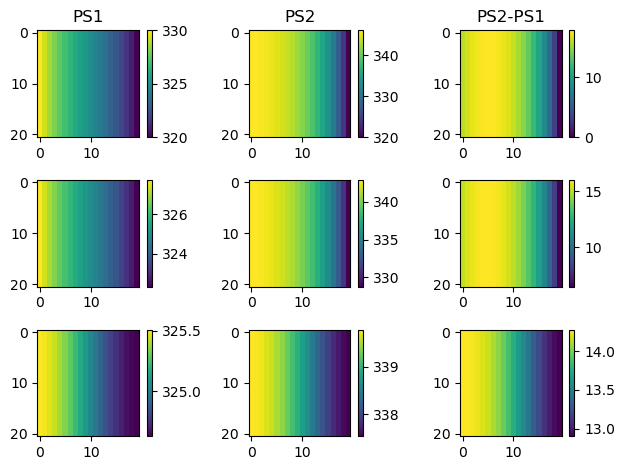

In [25]:
fig, ax = plt.subplots(3,3)
for i in range(m1head.shape[0]):
    d=ax[i,0].imshow(m1head[i])
    plt.colorbar(d)
    d=ax[i,1].imshow(m2ahead[i])
    plt.colorbar(d)
    d=ax[i,2].imshow(m2ahead[i]-m1head[i])
    plt.colorbar(d)
ax[0,0].set_title('PS1')
ax[0,1].set_title('PS2')
ax[0,2].set_title('PS2-PS1')

plt.tight_layout()

### Exercise 4: Between which columns does flow switch from down to up across layer 1?

col: 1 head_diff: 3.139358130637163
col: 2 head_diff: 3.1115587070364086
col: 3 head_diff: 3.055255056545093
col: 4 head_diff: 2.96902474448126
col: 5 head_diff: 2.850675019949506
col: 6 head_diff: 2.697173995793719
col: 7 head_diff: 2.5045569237848895
col: 8 head_diff: 2.26779496400286
col: 9 head_diff: 1.980618746708501
col: 10 head_diff: 1.6352990799691156
col: 11 head_diff: 1.2223562445735183
col: 12 head_diff: 0.7301795836071392
col: 13 head_diff: 0.14453304665556743
col: 14 head_diff: -0.5521026707930332
col: 15 head_diff: -1.3814223880709164
col: 16 head_diff: -2.370533431724141
col: 17 head_diff: -3.55371072880223
col: 18 head_diff: -4.974969435243281
col: 19 head_diff: -6.692000729012875
col: 20 head_diff: -8.783562097717208


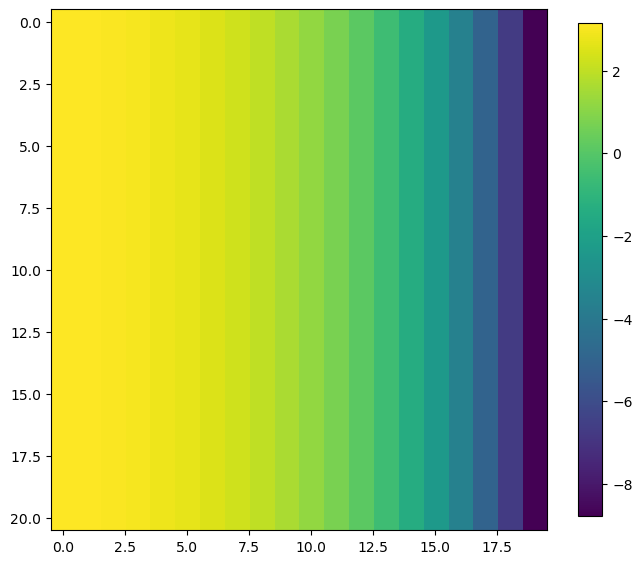

In [26]:
fig=plt.figure(figsize=(8,8))
dd = m2ahead[0,:,:]-m2ahead[1,:,:]
for i,j in enumerate(dd[0,:]):
    print(f'col: {i+1} head_diff: {j}')
#dd[dd<=0]=np.nan
plt.imshow(dd)
plt.colorbar(shrink=.8)

### exercise 5: calculate the volumetric flow rates between columns identified above
### note: the difference is between columns 13 and 14, but `flopy` as a python code uses zero-based indexing, so use 12 and 13 as the columns

In [27]:
table = pd.DataFrame(data={'layer':[0,1,2],'hleft':m2ahead[:,0,12], 'hright':m2ahead[:,0,13]})
table.set_index('layer',drop=True, inplace=True)
table

,hleft,hright
layer,,
0,338.755223,337.189357
1,338.610690,337.741460
2,338.466818,338.291474


### Remember:
### $Q=\left[-\frac{KA}{L}\right]\Delta h$
### and - will want to multiply by the number of rows (21) as this is a parallel flow model

In [28]:
table['delh'] = table.hright-table.hleft
table['b'] = [np.mean((table.loc[0].hright,table.loc[0].hleft))-
            m.dis.botm.array[0,0,0], 20, 200]
table['k'] = m.npf.k.array[:,0,12]
table['Q'] = [np.round(i) for i in 
            -table.k * table.b * table.delh *21 ]

In [29]:
table

,hleft,hright,delh,b,k,Q
layer,,,,,,
0,338.755223,337.189357,-1.565866,117.97229,50.00,193965.0
1,338.610690,337.741460,-0.869230,20.00000,0.01,4.0
2,338.466818,338.291474,-0.175344,200.00000,200.00,147289.0


### excercise 6: copy to PS2A1 and double K to see what happens

In [30]:
shutil.copytree('./ps2a/', './ps2a1', dirs_exist_ok=True)

'./ps2a1'

In [31]:
sim = flopy.mf6.MFSimulation.load(sim_ws = './ps2a1/', exe_name=mfexe)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package rch...
    loading package oc...
    loading package chd...
    loading package npf...
    loading package ic...
  loading solution package ps2...


In [32]:
m = sim.get_model()

In [33]:
# multiply both horizontal and vertical K by 2
m.npf.k = m.npf.k.array*2
m.npf.k33 = m.npf.k33.array*2

In [34]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ps2...
  writing model ps2...
    writing model name file...
    writing package dis...
    writing package rcha_0...
    writing package oc...
    writing package river...
    writing package npf...
    writing package ic...
FloPy is using the following executable to run the model: ../../bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.0 12/19/2024

        MODFLOW 6 compiled Dec 19 2024 21:26:44 with GCC version 13.3.0

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, expressed or 
implied, is made by the USGS or the U.S. Government as to the 
function

(True, [])

### read in the head output data

In [35]:
m2a1head = m.output.head().get_data()

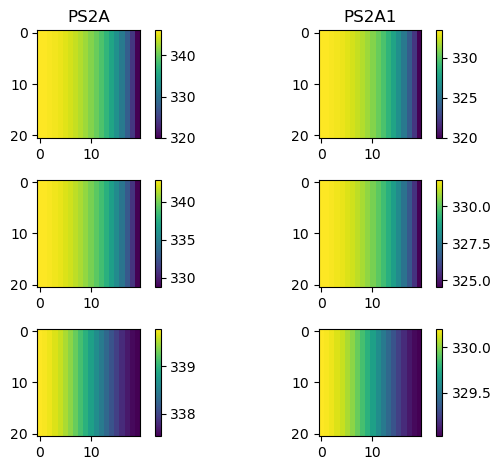

In [36]:
fig, ax = plt.subplots(3,2)
for i in range(m1head.shape[0]):
    d=ax[i,0].imshow(m2ahead[i])
    plt.colorbar(d)
    d=ax[i,1].imshow(m2a1head[i])
    plt.colorbar(d)
ax[0,0].set_title('PS2A')
ax[0,1].set_title('PS2A1')

plt.tight_layout()


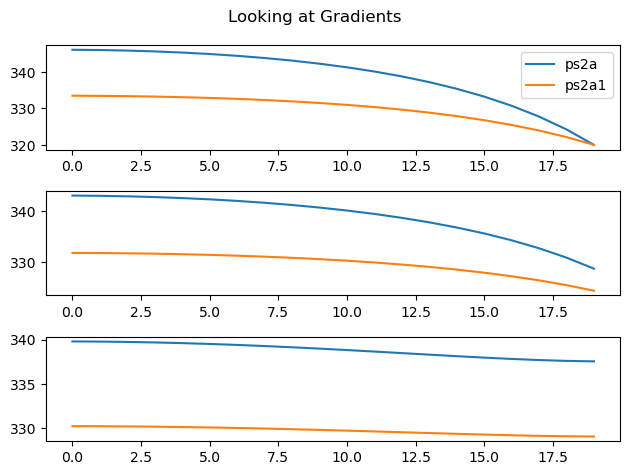

In [37]:
fig, ax = plt.subplots(3,1)
for i in range(m1head.shape[0]):
    d=ax[i].plot(m2ahead[i,0,:], label='ps2a')
    d=ax[i].plot(m2a1head[i,0,:], label='ps2a1')
ax[0].legend()
plt.suptitle('Looking at Gradients')
plt.tight_layout()


### read in the listing file budget information

In [38]:
m2a1_bud = m.output.list().get_dataframes()[0]

### note that the overall budgets are unchanged

In [39]:
m2a1_bud

,RCHA_IN,CHD_IN,TOTAL_IN,RCHA_OUT,CHD_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
1970-01-02,498750.0,0.0,498750.0,0.0,498751.15625,498751.15625,-1.169,-0.0


In [40]:
m2a1_bud

,RCHA_IN,CHD_IN,TOTAL_IN,RCHA_OUT,CHD_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
1970-01-02,498750.0,0.0,498750.0,0.0,498751.15625,498751.15625,-1.169,-0.0


### Exercise 7: Set up some budgets for the zones indicated

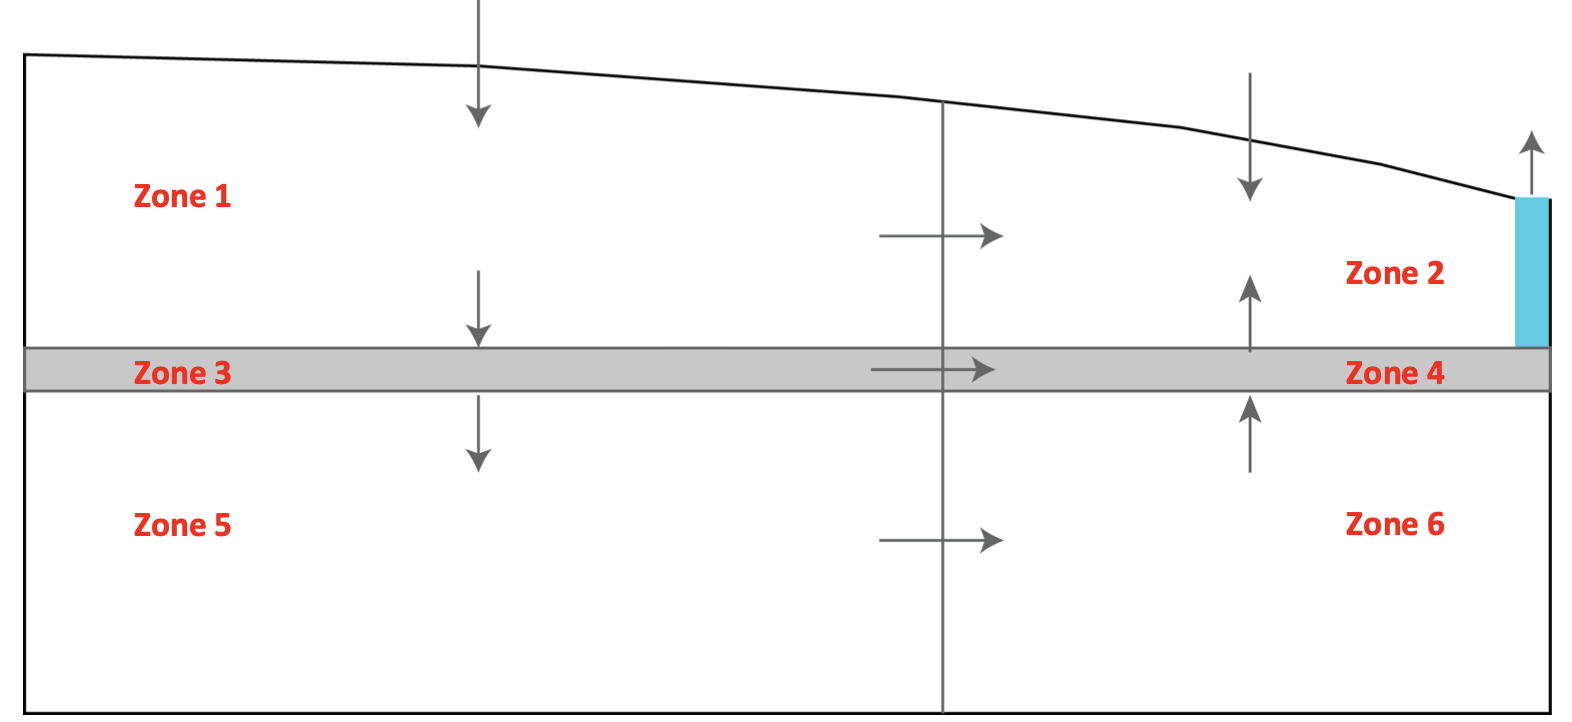

In [41]:
r = m.rch.recharge[0][0]
r

0.005

In [42]:
# these are just recharge multiplied by area
Zone1_in = r*21*13*500*500
Zone2_in = r*21*6*500*500
Zone1_in, Zone2_in

(341250.0, 157500.0)

In [43]:
# we already calculated the lateral exchanges Zone 1->2, 3->4, and 5->6 in the table above
table.Q

layer
0    193965.0
1         4.0
2    147289.0
Name: Q, dtype: float64

#### use these known amounts to fill in the diagram

In [44]:
Zone_1_3 = Zone1_in-table.loc[0].Q
Zone_1_3

147285.0

In [45]:
Zone_3_5 = Zone_1_3-table.loc[1].Q
Zone_3_5

147281.0

In [46]:
Zone_6_4 = table.loc[2].Q
Zone_6_4

147289.0

In [47]:
Zone_4_2 = Zone_6_4 + table.loc[1].Q
Zone_4_2

147293.0

In [48]:
Into_river = Zone2_in + Zone_4_2 + table.loc[0].Q
Into_river

498758.0

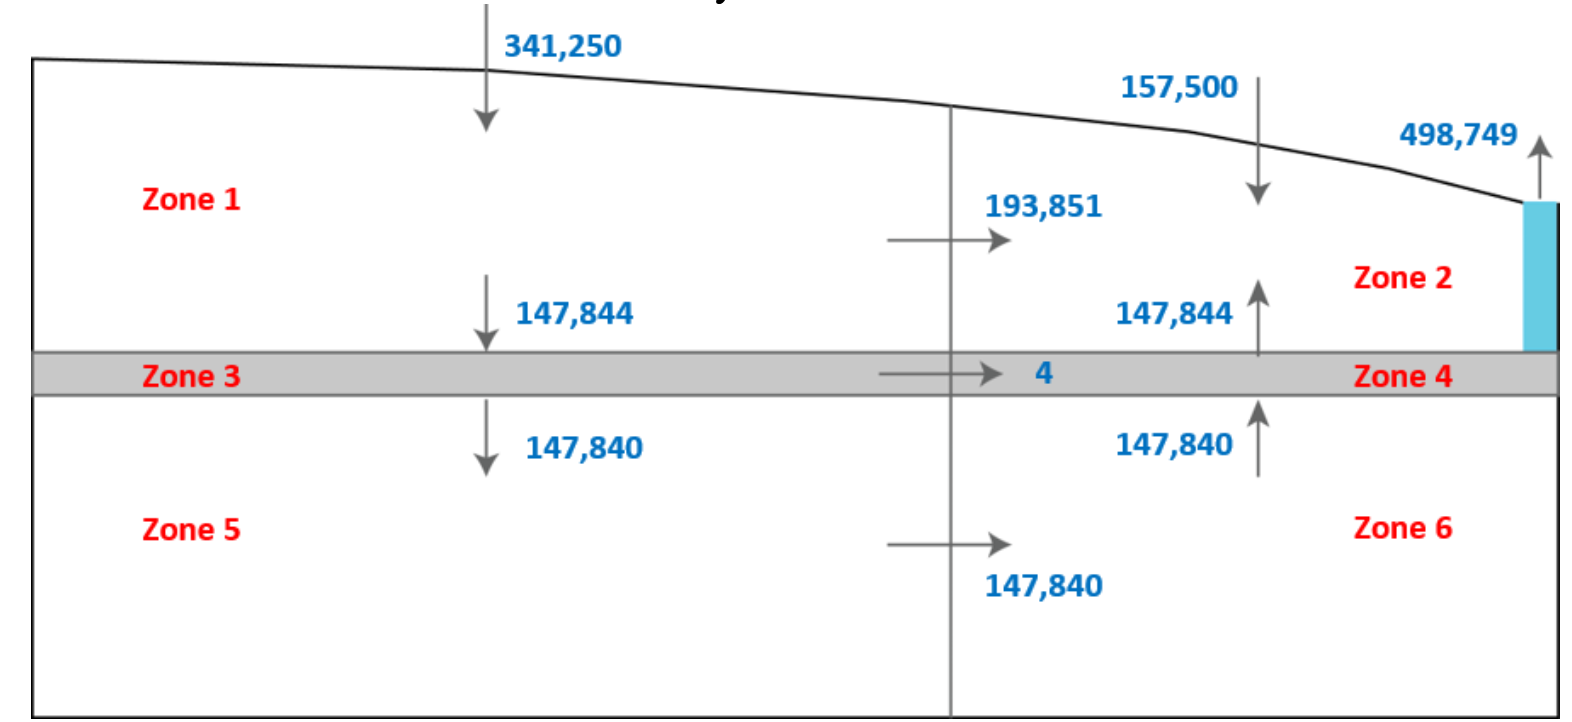

### exercise 8: figure out width of source area supplying R into layer 3

In [49]:
# R into layer 3 is Zone_3_5
Zone_3_5

147281.0

In [50]:
#width x length_of_model * R = Zone_3_5
# width x 10,500 x 0.005 = Zone_3_5
width = Zone_3_5/(10500*.005)
width

2805.352380952381

# Part B: River Package

In [51]:
if os.path.exists('./ps2b'):
    shutil.rmtree('./ps2b')
shutil.copytree('./ps2a/', './ps2b', dirs_exist_ok=True)

'./ps2b'

In [52]:
# read in the model
sim = flopy.mf6.MFSimulation.load(sim_ws = './ps2b/', exe_name=mfexe)
m = sim.get_model()
m.remove_package(m.chd)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package rch...
    loading package oc...
    loading package chd...
    loading package npf...
    loading package ic...
  loading solution package ps2...


In [53]:
# set the cells for which rivers will exist
rivcells = [(0,i,19) for i in range(m.dis.nrow.array)]
rivcells

[(0, 0, 19),
 (0, 1, 19),
 (0, 2, 19),
 (0, 3, 19),
 (0, 4, 19),
 (0, 5, 19),
 (0, 6, 19),
 (0, 7, 19),
 (0, 8, 19),
 (0, 9, 19),
 (0, 10, 19),
 (0, 11, 19),
 (0, 12, 19),
 (0, 13, 19),
 (0, 14, 19),
 (0, 15, 19),
 (0, 16, 19),
 (0, 17, 19),
 (0, 18, 19),
 (0, 19, 19),
 (0, 20, 19)]

In [54]:
# calculate the conductance for the river
# river bed K * length * width
# 20 * 500 * 10

In [55]:
# now make the stress period data for the river
riv_spd = pd.DataFrame(data={'cellid':rivcells,'stage':320, 'cond':20*500*10, 'rbot':317})

In [56]:
riv_spd

,cellid,stage,cond,rbot
0,"(0, 0, 19)",320,100000,317
1,"(0, 1, 19)",320,100000,317
2,"(0, 2, 19)",320,100000,317
3,"(0, 3, 19)",320,100000,317
4,"(0, 4, 19)",320,100000,317
5,"(0, 5, 19)",320,100000,317
6,"(0, 6, 19)",320,100000,317
7,"(0, 7, 19)",320,100000,317
8,"(0, 8, 19)",320,100000,317
9,"(0, 9, 19)",320,100000,317


In [57]:
riv = flopy.mf6.ModflowGwfriv(m, save_flows=True, stress_period_data=riv_spd.to_records(index=None))

In [58]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ps2...
  writing model ps2...
    writing model name file...
    writing package dis...
    writing package rcha_0...
    writing package oc...
    writing package npf...
    writing package ic...
    writing package riv_0...
INFORMATION: maxbound in ('gwf6', 'riv', 'dimensions') changed to 21 based on size of stress_period_data
FloPy is using the following executable to run the model: ../../bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.0 12/19/2024

        MODFLOW 6 compiled Dec 19 2024 21:26:44 with GCC version 13.3.0

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and r

(True, [])

In [59]:
m2bhead = m.output.head().get_data()

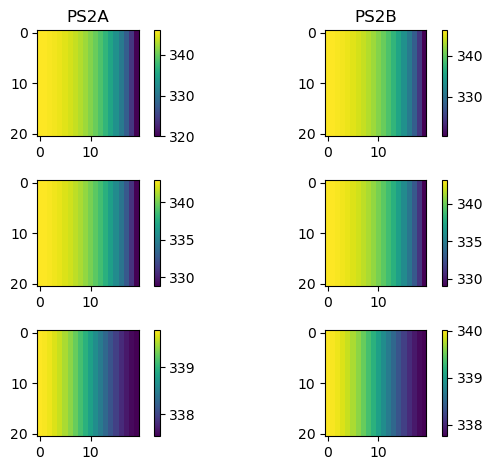

In [60]:
fig, ax = plt.subplots(3,2)
for i in range(m1head.shape[0]):
    d=ax[i,0].imshow(m2ahead[i])
    plt.colorbar(d)
    d=ax[i,1].imshow(m2bhead[i])
    plt.colorbar(d)
ax[0,0].set_title('PS2A')
ax[0,1].set_title('PS2B')
plt.tight_layout()

In [61]:
m2b_bud = m.output.list().get_dataframes()[0]

In [62]:
m2a1_bud

,RCHA_IN,CHD_IN,TOTAL_IN,RCHA_OUT,CHD_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
1970-01-02,498750.0,0.0,498750.0,0.0,498751.15625,498751.15625,-1.169,-0.0


In [63]:
m2b_bud

,RIV_IN,RCHA_IN,TOTAL_IN,RIV_OUT,RCHA_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
1970-01-02,0.0,525000.0,525000.0,525000.125,0.0,525000.125,-0.1027,-0.0


### excercise 9: 
### identify all the inflow and outflow terms for cell 1,1,20 (remember - use zero-based indices so 0,0,19). Compare the result to the flux to the River. close?

In [64]:
# Qriv = (Qrch + Qleft + Qbot)

In [65]:
k=50

In [66]:
Q_rch = 500 * 500 * 0.005 #(dx x dy x R)
Q_rch

1250.0

### flow from the left cell

In [67]:
k=50
delh_left = m2bhead[0,0,19]-m2bhead[0,0,18]
b = np.mean((m2bhead[0,0,19],m2bhead[0,0,18]))-220

Q_left = -k * b * 500  * delh_left / 500
Q_left

21586.26482584658

### flow from the "south" cell

In [68]:
k=50
delh_south = m2bhead[0,0,19]-m2bhead[0,1,19]
b = np.mean((m2bhead[0,0,19],m2bhead[0,1,19]))-220

Q_south = -k * b * 500  * delh_south / 500
Q_south

0.00013752744728984405

### Flow from the bottom cell:  
### tricky here, but best to calculate the half-cell conductances. Why? Because need to basically account for partial length when calculating an "average" K

In [69]:
delh_bot = m2bhead[0,0,19]-m2bhead[1,0,19]

C1 = 10 * 500 * 500 / ((m.dis.top.array[0,19]-m.dis.botm.array[0,0,19])/2)
C2 = 0.01 * 500 * 500 / 10
Q_bot = -C1*C2/(C1+C2) * delh_bot 
Q_bot

2172.905485682462

In [70]:
# or approx version
Q_bot_approx = -C2*delh_bot
Q_bot_approx

2192.4616350536044

In [71]:
Q_riv = 525000 / 21
Q_riv

25000.0

In [72]:
Q_bot + Q_rch + Q_left + Q_south

25009.17044905649

# Part C: Drain and General Head Boundaries

In [73]:
if os.path.exists('./ps2c/'):
    shutil.rmtree('./ps2c')
shutil.copytree('./ps2b/', './ps2c', dirs_exist_ok=True)

'./ps2c'

In [74]:
# read in the model
sim = flopy.mf6.MFSimulation.load(sim_ws = './ps2c/', exe_name=mfexe)
m = sim.get_model()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package oc...
    loading package rch...
    loading package riv...
  loading solution package ps2...


### add the drains

In [75]:
drain_cells = [(0,14,i) for i in range(9,20)]
drn_spd = pd.DataFrame(data={'cellid':drain_cells, 'elev':322.5, 'cond':1e5})
drn_spd

,cellid,elev,cond
0,"(0, 14, 9)",322.5,100000.0
1,"(0, 14, 10)",322.5,100000.0
2,"(0, 14, 11)",322.5,100000.0
3,"(0, 14, 12)",322.5,100000.0
4,"(0, 14, 13)",322.5,100000.0
5,"(0, 14, 14)",322.5,100000.0
6,"(0, 14, 15)",322.5,100000.0
7,"(0, 14, 16)",322.5,100000.0
8,"(0, 14, 17)",322.5,100000.0
9,"(0, 14, 18)",322.5,100000.0


In [76]:
drn = flopy.mf6.ModflowGwfdrn(m, print_flows=True, stress_period_data=drn_spd.to_records(index=None))

In [77]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ps2...
  writing model ps2...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package oc...
    writing package rcha_0...
    writing package riv_0...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 11 based on size of stress_period_data
FloPy is using the following executable to run the model: ../../bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.0 12/19/2024

        MODFLOW 6 compiled Dec 19 2024 21:26:44 with GCC version 13.3.0

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursu

(True, [])

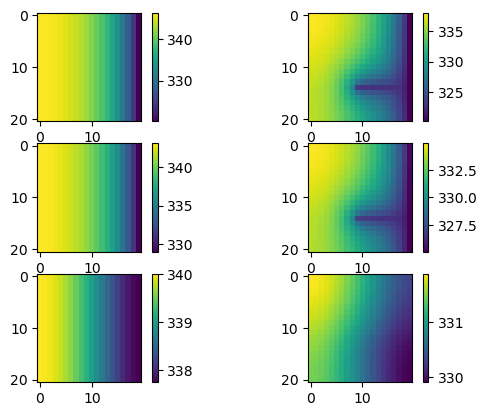

In [78]:
m2chead = m.output.head().get_data()
fig, ax = plt.subplots(3,2)
for i in range(m1head.shape[0]):
    d=ax[i,0].imshow(m2bhead[i])
    plt.colorbar(d)
    d=ax[i,1].imshow(m2chead[i])
    plt.colorbar(d)


### Exercise 10: check out drain discharge differences between 1,15,18 and 1,15,19

In [79]:
lst = open('./ps2c/ps2.lst', 'r').readlines()
strtline = [lst.index(i) for i in lst if 'DRN PACKAGE (DRN_0) FLOW RATES ' in i][0]

In [80]:
[print(i.strip()) for i in lst[strtline:strtline+16]];

DRN PACKAGE (DRN_0) FLOW RATES   PERIOD      1   STEP        1
-----------------------------------------------
NUMBER   CELLID                    RATE
-----------------------------------------------
1      (1,15,10)            -68577.932
2      (1,15,11)            -35533.246
3      (1,15,12)            -28839.171
4      (1,15,13)            -25083.111
5      (1,15,14)            -22088.853
6      (1,15,15)            -19179.605
7      (1,15,16)            -15883.623
8      (1,15,17)            -11505.214
9      (1,15,18)            -2028.5365
10     (1,15,19)             0.0000000
11     (1,15,20)             0.0000000
-----------------------------------------------


In [81]:
# heads go below the drain so no flow into the drain at col. 18
m2chead[0,14,:]-322.5

array([13.88842952, 13.74952561, 13.46469442, 13.01845836, 12.3832588 ,
       11.51131239, 10.31477503,  8.60936082,  5.92125881,  0.68577932,
        0.35533246,  0.28839171,  0.25083111,  0.22088853,  0.19179605,
        0.15883623,  0.11505214,  0.02028537, -0.84548751, -2.3965272 ])

In [82]:
# we are going to need this a little later
m2c_bud = m.output.list().get_dataframes()[0]

### Exercise 11: copy to PS2C1 and replace DRN with GHB using the same information

In [83]:
shutil.copytree('./ps2c/', './ps2c1', dirs_exist_ok=True)

'./ps2c1'

In [84]:
# read in the model
sim = flopy.mf6.MFSimulation.load(sim_ws = './ps2c1/', exe_name=mfexe)
sim.set_sim_path('ps2c1')
m = sim.get_model()
m.remove_package(m.drn)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package oc...
    loading package rch...
    loading package riv...
    loading package drn...
  loading solution package ps2...


In [85]:
# confirm we removed the drain package in the cell above
m.get_package_list()

['DIS', 'IC', 'NPF', 'OC', 'RCHA_0', 'RIV_0']

In [86]:
drn_spd.to_records(index=None)

rec.array([((0, 14, 9), 322.5, 100000.), ((0, 14, 10), 322.5, 100000.),
           ((0, 14, 11), 322.5, 100000.), ((0, 14, 12), 322.5, 100000.),
           ((0, 14, 13), 322.5, 100000.), ((0, 14, 14), 322.5, 100000.),
           ((0, 14, 15), 322.5, 100000.), ((0, 14, 16), 322.5, 100000.),
           ((0, 14, 17), 322.5, 100000.), ((0, 14, 18), 322.5, 100000.),
           ((0, 14, 19), 322.5, 100000.)],
          dtype=[('cellid', 'O'), ('elev', '<f8'), ('cond', '<f8')])

In [87]:
# now make a GHB package using the same information as was in the DRN package
# but first rename the head column
ghb_spd = drn_spd.copy().rename(columns={'elev':'bhead'})
ghb_spd

,cellid,bhead,cond
0,"(0, 14, 9)",322.5,100000.0
1,"(0, 14, 10)",322.5,100000.0
2,"(0, 14, 11)",322.5,100000.0
3,"(0, 14, 12)",322.5,100000.0
4,"(0, 14, 13)",322.5,100000.0
5,"(0, 14, 14)",322.5,100000.0
6,"(0, 14, 15)",322.5,100000.0
7,"(0, 14, 16)",322.5,100000.0
8,"(0, 14, 17)",322.5,100000.0
9,"(0, 14, 18)",322.5,100000.0


In [88]:
ghb = flopy.mf6.ModflowGwfghb(m, stress_period_data=ghb_spd.to_records(index=None), print_flows=True)

In [89]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ps2...
  writing model ps2...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package oc...
    writing package rcha_0...
    writing package riv_0...
    writing package ghb_0...
INFORMATION: maxbound in ('gwf6', 'ghb', 'dimensions') changed to 11 based on size of stress_period_data
FloPy is using the following executable to run the model: ../../bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.0 12/19/2024

        MODFLOW 6 compiled Dec 19 2024 21:26:44 with GCC version 13.3.0

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursu

(True, [])

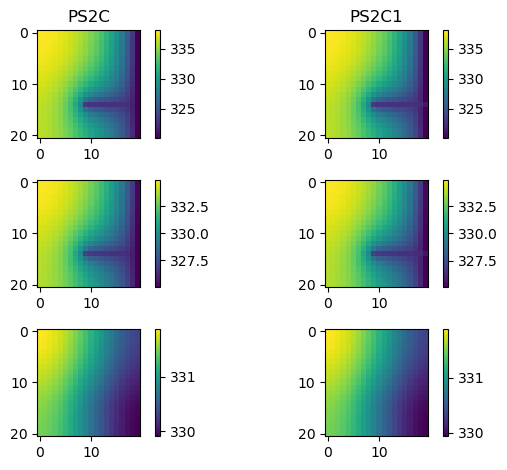

In [90]:
m2c1head = m.output.head().get_data()
fig, ax = plt.subplots(3,2)
for i in range(m1head.shape[0]):
    d=ax[i,0].imshow(m2chead[i])
    plt.colorbar(d)
    d=ax[i,1].imshow(m2c1head[i])
    plt.colorbar(d)
ax[0,0].set_title('PS2C')
ax[0,1].set_title('PS2C1')
plt.tight_layout()

In [91]:
lst = open('./ps2c1/ps2.lst', 'r').readlines()
strtline = [lst.index(i) for i in lst if 'GHB PACKAGE (GHB_0) FLOW RATES ' in i][0]

### So how does GHB flow rate change relative to the DRN version?

In [92]:
[print(i.strip()) for i in lst[strtline:strtline+16]];

GHB PACKAGE (GHB_0) FLOW RATES   PERIOD      1   STEP        1
-----------------------------------------------
NUMBER   CELLID                    RATE
-----------------------------------------------
1      (1,15,10)            -68675.578
2      (1,15,11)            -35591.825
3      (1,15,12)            -28896.505
4      (1,15,13)            -25147.817
5      (1,15,14)            -22171.223
6      (1,15,15)            -19300.008
7      (1,15,16)            -16094.814
8      (1,15,17)            -12057.213
9      (1,15,18)            -6183.7836
10     (1,15,19)             7323.4278
11     (1,15,20)             126185.33
-----------------------------------------------


In [93]:
lst = open('./ps2c/ps2.lst', 'r').readlines()
strtline = [lst.index(i) for i in lst if 'DRN PACKAGE (DRN_0) FLOW RATES ' in i][0]
[print(i.strip()) for i in lst[strtline:strtline+16]];

DRN PACKAGE (DRN_0) FLOW RATES   PERIOD      1   STEP        1
-----------------------------------------------
NUMBER   CELLID                    RATE
-----------------------------------------------
1      (1,15,10)            -68577.932
2      (1,15,11)            -35533.246
3      (1,15,12)            -28839.171
4      (1,15,13)            -25083.111
5      (1,15,14)            -22088.853
6      (1,15,15)            -19179.605
7      (1,15,16)            -15883.623
8      (1,15,17)            -11505.214
9      (1,15,18)            -2028.5365
10     (1,15,19)             0.0000000
11     (1,15,20)             0.0000000
-----------------------------------------------


# Part D: Well Package

In [94]:
if os.path.exists('./ps2d/'):
    shutil.rmtree('./ps2d')
shutil.copytree('./ps2c/', './ps2d', dirs_exist_ok=True)

'./ps2d'

In [95]:
# read in the model
sim = flopy.mf6.MFSimulation.load(sim_ws = './ps2d/', exe_name=mfexe)
m = sim.get_model()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package oc...
    loading package rch...
    loading package riv...
    loading package drn...
  loading solution package ps2...


In [96]:
wel = flopy.mf6.ModflowGwfwel(m, stress_period_data=[[(0,10,9), -75000]])

In [97]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ps2...
  writing model ps2...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package oc...
    writing package rcha_0...
    writing package riv_0...
    writing package drn_0...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 1 based on size of stress_period_data
FloPy is using the following executable to run the model: ../../bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.0 12/19/2024

        MODFLOW 6 compiled Dec 19 2024 21:26:44 with GCC version 13.3.0

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update t

(True, [])

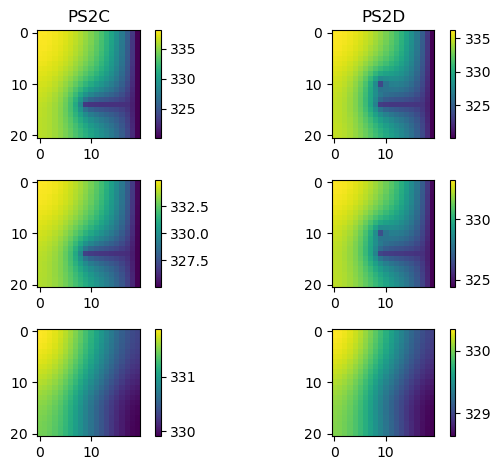

In [98]:
m2dhead = m.output.head().get_data()
fig, ax = plt.subplots(3,2)
for i in range(m1head.shape[0]):
    d=ax[i,0].imshow(m2chead[i])
    plt.colorbar(d)
    d=ax[i,1].imshow(m2dhead[i])
    plt.colorbar(d)
ax[0,0].set_title('PS2C')
ax[0,1].set_title('PS2D')
plt.tight_layout()

In [99]:
m2d_bud = m.output.list().get_dataframes()[0]

In [100]:
m2d_bud

,WEL_IN,DRN_IN,RIV_IN,RCHA_IN,TOTAL_IN,WEL_OUT,DRN_OUT,RIV_OUT,RCHA_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
1970-01-02,0.0,0.0,0.0,525000.0,525000.0,75000.0,180065.9375,269935.0,0.0,525000.9375,-0.9467,-0.0


In [101]:
m2c_bud

,DRN_IN,RIV_IN,RCHA_IN,TOTAL_IN,DRN_OUT,RIV_OUT,RCHA_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY
1970-01-02,0.0,0.0,525000.0,525000.0,228719.296875,296283.03125,0.0,525002.3125,-2.3256,-0.0


In [102]:
table_c_to_d = pd.DataFrame(data = {'package':['RIV','DRN','WEL'],
                                   'PS2D':[m2d_bud['RIV_OUT'].values[0],
                                          m2d_bud['DRN_OUT'].values[0],
                                          m2d_bud['WEL_OUT'].values[0]],
                                   'PS2C':[m2c_bud['RIV_OUT'].values[0],
                                          m2c_bud['DRN_OUT'].values[0],
                                          0]})
table_c_to_d['PS2D-PS2C'] = table_c_to_d.PS2D-table_c_to_d.PS2C

In [103]:
table_c_to_d

,package,PS2D,PS2C,PS2D-PS2C
0,RIV,269935.0000,296283.031250,-26348.031250
1,DRN,180065.9375,228719.296875,-48653.359375
2,WEL,75000.0000,0.000000,75000.000000


In [104]:
table_c_to_d['PS2D-PS2C'].sum()

-1.390625

# PART E: Transient Flow

In [105]:
if os.path.exists('./ps2e/'):
    shutil.rmtree('./ps2e')
shutil.copytree('./ps2d/', './ps2e', dirs_exist_ok=True)

'./ps2e'

In [106]:
# read in the model
sim = flopy.mf6.MFSimulation.load(sim_ws = './ps2e/', exe_name=mfexe)
m = sim.get_model()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package npf...
    loading package oc...
    loading package rch...
    loading package riv...
    loading package drn...
    loading package wel...
  loading solution package ps2...


In [107]:
sim.tdis.nper=3
simpd = pd.DataFrame(data={'perlen':[300000,36500,300000],
                          'nstp':[1,10,1],
                          'tsmult':[1,1.5,1]})
sim.tdis.perioddata = simpd.to_records(index=None)

In [108]:
sto = flopy.mf6.ModflowGwfsto(m, sy=0.1, ss=0.0001, iconvert=1, steady_state={0:True,1:False,2:True},
                             transient={0:False,1:True,2:False})

In [109]:
sim.tdis.perioddata

{internal}
(rec.array([(300000,  1, 1. ), ( 36500, 10, 1.5), (300000,  1, 1. )],
          dtype=[('perlen', '<i8'), ('nstp', '<i8'), ('tsmult', '<f8')]))

### add the second well with the proper timing

In [110]:
m.remove_package(m.wel)

In [111]:
wel_spd = {0:[[(0,10,9), -75000]],
           1:[[(0,10,9), -75000],[(2,12,4), -100000]],
           2:[[(0,10,9), -75000],[(2,12,4), -100000]]}

In [112]:
wel = flopy.mf6.ModflowGwfwel(m, stress_period_data=wel_spd)

In [113]:
# m.oc.printrecord

In [114]:
saverecord = pd.DataFrame(data={'rtype':['head','budget'], 
                                'ocsetting':['all','all'],
                                'ocsetting_data':[None, None]})

In [115]:
# m.oc.saverecord = {i:saverecord.to_records(index=None) for i in range(3)}

In [116]:
sim.write_simulation()
sim.run_simulation()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ps2...
  writing model ps2...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package npf...
    writing package oc...
    writing package rcha_0...
    writing package riv_0...
    writing package drn_0...
    writing package sto...
    writing package wel_0...
INFORMATION: maxbound in ('gwf6', 'wel', 'dimensions') changed to 2 based on size of stress_period_data
FloPy is using the following executable to run the model: ../../bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.0 12/19/2024

        MODFLOW 6 compiled Dec 19 2024 21:26:44 with GCC version 13.3.0

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS res

(True, [])

In [117]:
times = m.output.head().get_times()

In [118]:
times

[300000.0,
 300322.068074106,
 300805.170185265,
 301529.82335200347,
 302616.8031021112,
 304247.27272727276,
 306692.9771650151,
 310361.53382162866,
 315864.36880654894,
 324118.6212839294,
 336500.0,
 636500.0]

In [119]:
m2ehead = np.array([m.output.head().get_data(totim=i) for i in times])
m2ehead.shape

(12, 3, 21, 20)

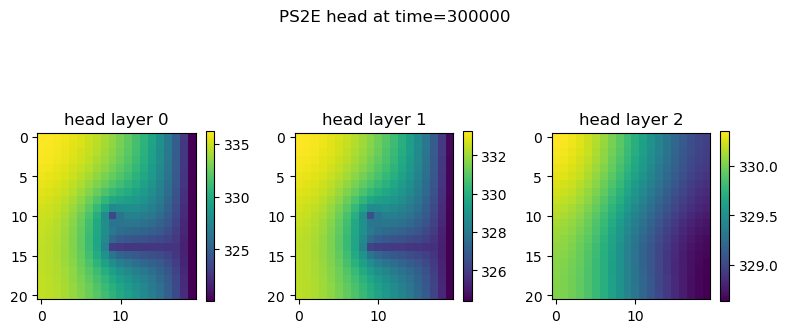

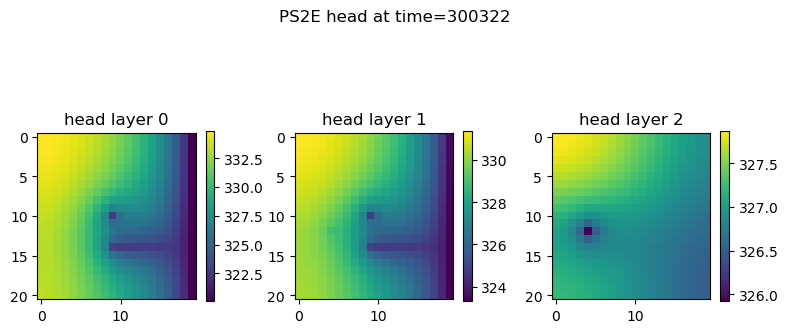

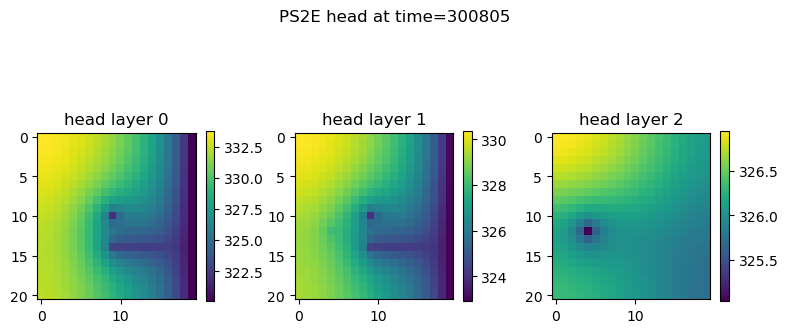

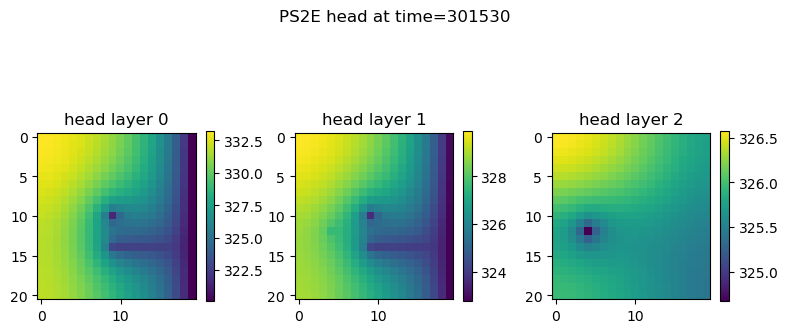

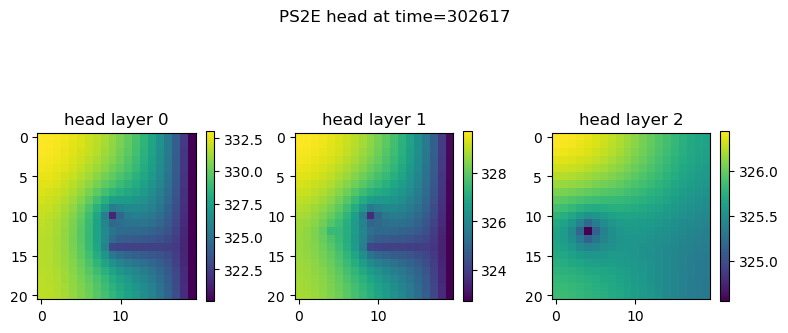

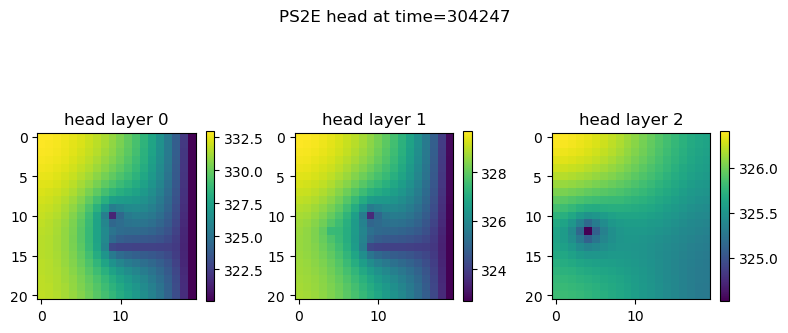

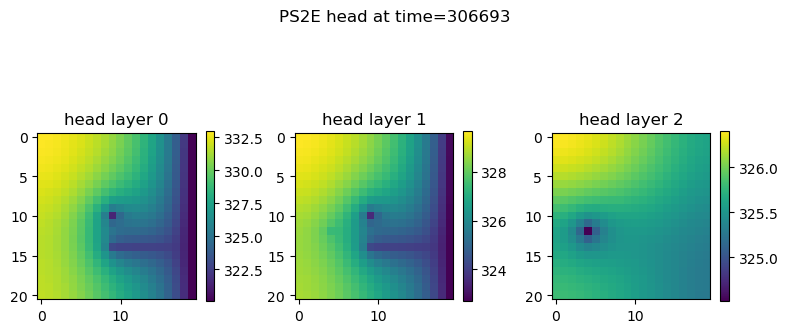

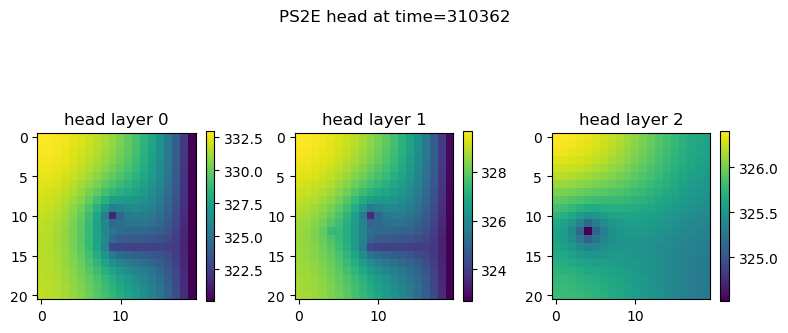

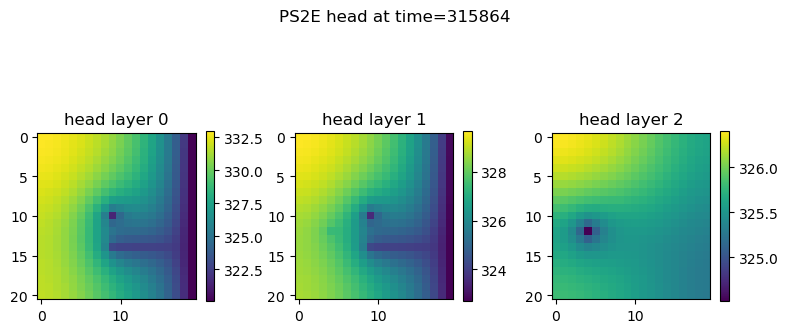

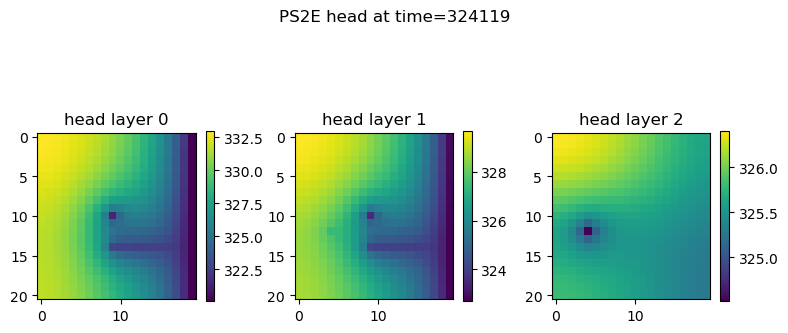

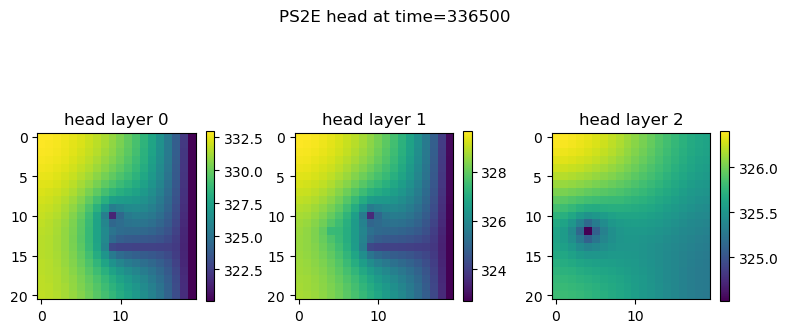

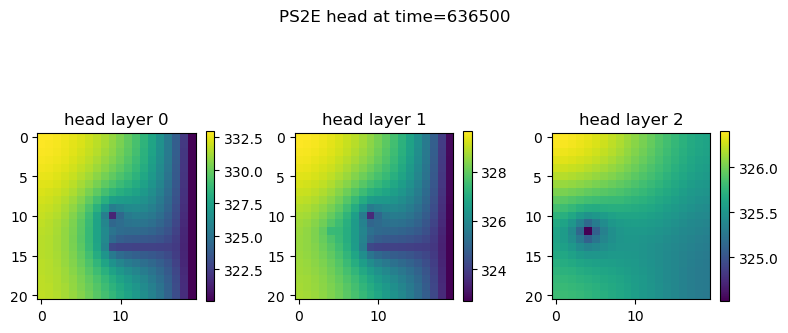

In [120]:
for t in range(len(times)):
    fig, ax = plt.subplots(1,3, figsize=(8,4))
    for i in range(3):
        d=ax[i].imshow(m2ehead[t,i,:,:])
        plt.colorbar(d, shrink=.5)
        ax[i].set_title(f'head layer {i}')
    plt.suptitle(f'PS2E head at time={times[t]:.0f}')
    plt.tight_layout()

### Exercise 13: Look at the budgets and see how storage interacts with the river and drain

In [121]:
m2e_budfile = fu.Mf6ListBudget('./ps2e/ps2.lst')

In [122]:
m2e_bud_inc, m2e_bud_cumul = m2e_budfile.get_budget()

In [123]:
m2e_bud_incdf = pd.DataFrame.from_records(m2e_bud_inc)
m2e_bud_incdf

,totim,time_step,stress_period,STO-SS_IN,STO-SY_IN,WEL_IN,DRN_IN,RIV_IN,RCHA_IN,TOTAL_IN,STO-SS_OUT,STO-SY_OUT,WEL_OUT,DRN_OUT,RIV_OUT,RCHA_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY,tslen
0,300000.0,0,0,0.000000,0.000000,0.0,0.0,0.0,525000.0,525000.0,0.000000,0.000000,75000.0,180065.937500,269935.000000,0.0,525000.9375,-0.9467,-0.0,300000.000000
1,336500.0,9,1,0.000175,0.001236,0.0,0.0,0.0,525000.0,525000.0,0.000013,0.000018,175000.0,127229.351562,222772.187500,0.0,525001.5000,-1.5289,-0.0,12381.400391
2,636500.0,0,2,0.000000,0.000000,0.0,0.0,0.0,525000.0,525000.0,0.000000,0.000000,175000.0,127229.312500,222772.140625,0.0,525001.4375,-1.4602,-0.0,300000.000000


<Axes: >

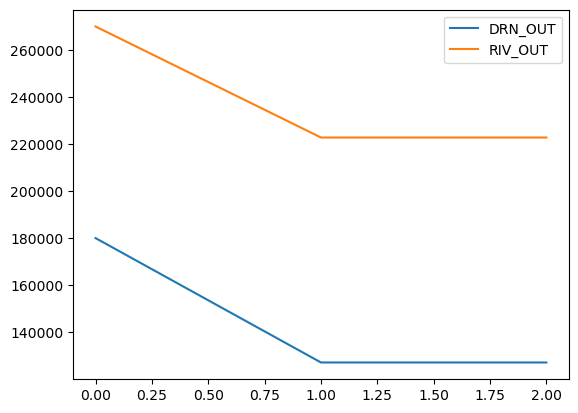

In [124]:
m2e_bud_incdf[['DRN_OUT','RIV_OUT']].plot()

<Axes: >

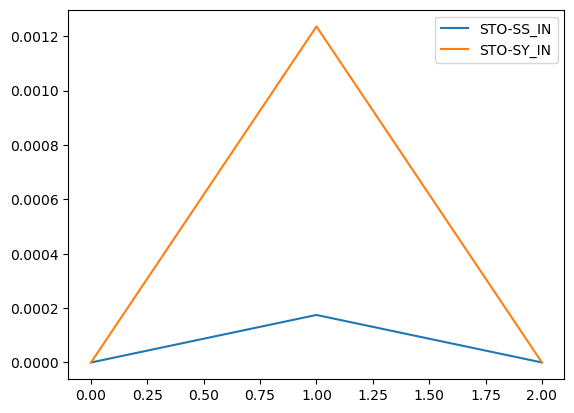

In [125]:
m2e_bud_incdf[['STO-SS_IN','STO-SY_IN']].plot()

### Excercise 14: Change the timing of the steady-state stress periods

In [126]:
if os.path.exists('./ps2e_changed/'):
    shutil.rmtree('./ps2e_changed')
shutil.copytree('./ps2e/', './ps2e_changed', dirs_exist_ok=True)

'./ps2e_changed'

In [127]:
# read in the model
sim = flopy.mf6.MFSimulation.load(sim_ws = './ps2e_changed/', exe_name=mfexe)
m = sim.get_model()

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package sto...
    loading package drn...
    loading package riv...
    loading package rch...
    loading package oc...
    loading package npf...
    loading package ic...
    loading package wel...
  loading solution package ps2...


In [128]:
sim.tdis.nper=3
simpd = pd.DataFrame(data={'perlen':[1,36500,1],
                          'nstp':[1,10,1],
                          'tsmult':[1,1.5,1]})
sim.tdis.perioddata = simpd.to_records(index=None)
sim.tdis.perioddata

{internal}
(rec.array([(    1,  1, 1. ), (36500, 10, 1.5), (    1,  1, 1. )],
          dtype=[('perlen', '<i8'), ('nstp', '<i8'), ('tsmult', '<f8')]))

In [129]:
sim.write_simulation()
sim.run_simulation()
m2e_changed_budfile = fu.Mf6ListBudget('./ps2e_changed/ps2.lst')
m2e_changed_bud_inc, m2e_changed_bud_cumul = m2e_changed_budfile.get_budget()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ps2...
  writing model ps2...
    writing model name file...
    writing package dis...
    writing package sto...
    writing package drn_0...
    writing package riv_0...
    writing package rcha_0...
    writing package oc...
    writing package npf...
    writing package ic...
    writing package wel_0...
FloPy is using the following executable to run the model: ../../bin/mf6
                                   MODFLOW 6
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.6.0 12/19/2024

        MODFLOW 6 compiled Dec 19 2024 21:26:44 with GCC version 13.3.0

This software has been approved for release by the U.S. Geological 
Survey (USGS). Although the software has been subjected to rigorous 
review, the USGS reserves the right to update the software as needed 
pursuant to further analysis and review. No warranty, 

In [130]:
m2e_changedbud_incdf = pd.DataFrame.from_records(m2e_changed_bud_inc)
m2e_changedbud_incdf

,totim,time_step,stress_period,STO-SS_IN,STO-SY_IN,WEL_IN,DRN_IN,RIV_IN,RCHA_IN,TOTAL_IN,STO-SS_OUT,STO-SY_OUT,WEL_OUT,DRN_OUT,RIV_OUT,RCHA_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY,tslen
0,1.0,0,0,0.000000,0.000000,0.0,0.0,0.0,525000.0,525000.0,0.000000,0.000000,75000.0,180065.937500,269935.000000,0.0,525000.9375,-0.9467,-0.0,1.000000
1,36501.0,9,1,0.000175,0.001236,0.0,0.0,0.0,525000.0,525000.0,0.000013,0.000018,175000.0,127229.351562,222772.187500,0.0,525001.5000,-1.5289,-0.0,12381.400391
2,36502.0,0,2,0.000000,0.000000,0.0,0.0,0.0,525000.0,525000.0,0.000000,0.000000,175000.0,127229.312500,222772.140625,0.0,525001.4375,-1.4602,-0.0,1.000000


In [131]:
# compare with the old longer times
m2e_bud_incdf

,totim,time_step,stress_period,STO-SS_IN,STO-SY_IN,WEL_IN,DRN_IN,RIV_IN,RCHA_IN,TOTAL_IN,STO-SS_OUT,STO-SY_OUT,WEL_OUT,DRN_OUT,RIV_OUT,RCHA_OUT,TOTAL_OUT,IN-OUT,PERCENT_DISCREPANCY,tslen
0,300000.0,0,0,0.000000,0.000000,0.0,0.0,0.0,525000.0,525000.0,0.000000,0.000000,75000.0,180065.937500,269935.000000,0.0,525000.9375,-0.9467,-0.0,300000.000000
1,336500.0,9,1,0.000175,0.001236,0.0,0.0,0.0,525000.0,525000.0,0.000013,0.000018,175000.0,127229.351562,222772.187500,0.0,525001.5000,-1.5289,-0.0,12381.400391
2,636500.0,0,2,0.000000,0.000000,0.0,0.0,0.0,525000.0,525000.0,0.000000,0.000000,175000.0,127229.312500,222772.140625,0.0,525001.4375,-1.4602,-0.0,300000.000000
